In [1]:
import numpy as np
import polars as pl
import plotnine as p9
from scipy.signal import convolve
from tqdm.notebook import tqdm
from mizani.formatters import scientific_format

In [ ]:
# Parameters
fs = 4800  # Hz
duration = 1.0  # seconds
t = np.linspace(0, duration, int(fs * duration))
N = 20 # number of motor units
tau = 0.005  # twitch decay constant
central_frequency = 80  # Hz
tikhonov_lambda = 1e-9  # Tikhonov regularization parameter

In [107]:
# Functions
def generate_spike_train(rate, duration, jitter=0.001, fs=1000):
    isi = np.random.normal(1/rate, jitter, size=int(rate * duration * 2))
    spike_times = np.cumsum(isi)
    spike_times = spike_times[spike_times < duration]
    spike_train = np.zeros(int(fs * duration))
    spike_idx = (spike_times * fs).astype(int)
    spike_train[spike_idx] = 1
    return spike_train

def twitch_kernel(t, tau):
    return t * np.exp(-t / tau)

def convolve_spikes_with_twitch(spike_train, fs=1000, tau=0.005):
    t_kernel = np.arange(0, 0.05, 1/fs)
    kernel = twitch_kernel(t_kernel, tau)
    return np.convolve(spike_train, kernel, mode='same')


In [108]:
# Generate spike trains and responses
unit_ids = []
timepoints = []
values = []
types = []
spikes = []

for i in range(N):
    rate = np.random.normal(central_frequency, 5)
    spike_train = generate_spike_train(rate, duration, jitter=0.001, fs=fs)
    response = 1.0 * convolve_spikes_with_twitch(spike_train, fs=fs, tau=tau)
    unit = f"Unit {i+1}"

    timepoints.extend(t)
    values.extend(response)
    spikes.extend(spike_train)
    unit_ids.extend([unit] * len(t))
    types.extend(["response"] * len(t))

# Create Polars DataFrame
df_pl = pl.DataFrame({
    "time": timepoints,
    "value": values,
    "spikes": spikes,
    "unit": unit_ids,
    "type": types
})

# Sum across units to get total OMT signal
omt_signal_df = (
    df_pl
    .group_by("time")
    .agg(pl.col("value").sum().alias("value"))
    .with_columns([
        pl.col("value").alias("spikes"),
        pl.lit("Summed").alias("unit"),
        pl.lit("signal").alias("type")
    ])
)
df_all = pl.concat([df_pl, omt_signal_df])


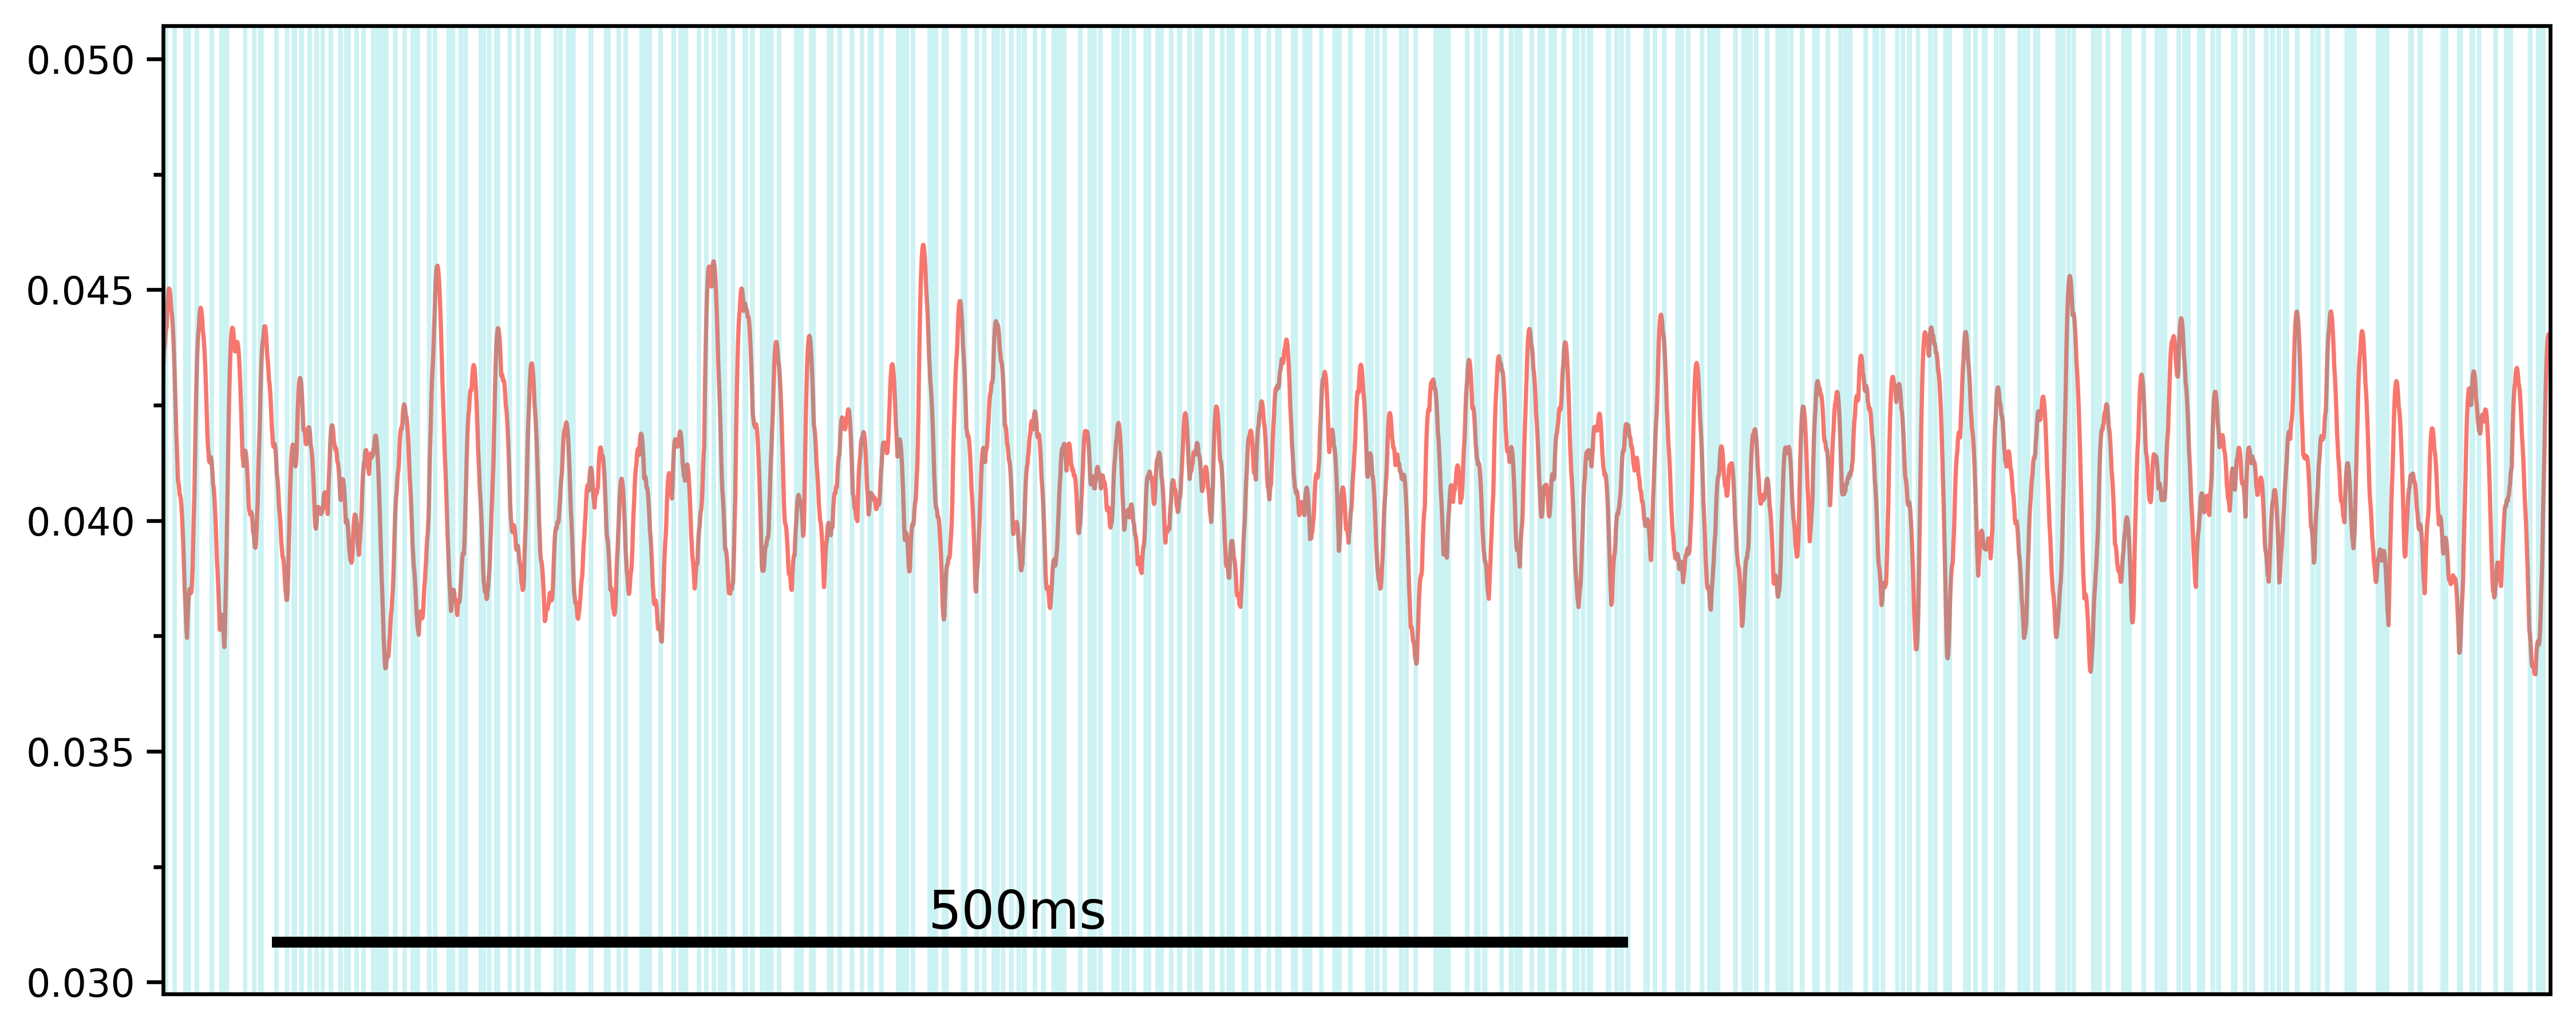

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 7.5 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 7.5 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal.pdf


In [117]:
# Plot using plotnine with facetting by unit
_df_fig_summed = df_all.filter(
    pl.col("unit").is_in(["Summed"])
)
required_units = [f"Unit {i+1}" for i in range(5)]
_df_fig_units = df_all.filter(
    pl.col("unit").is_in(required_units)
)
fig = (
    p9.ggplot(_df_fig_summed, p9.aes(x="time", y="spikes", color="type")) +
    p9.geom_line() +
    p9.geom_line(data=_df_fig_units, alpha=0.2) +
    p9.annotate("rect", xmin=0.1, xmax=0.60, ymin=_df_fig_summed["spikes"].mean() - 1.95 * _df_fig_summed["spikes"].std(), ymax=_df_fig_summed["spikes"].mean() - 1.90 * _df_fig_summed["spikes"].std(), fill="black") +
    p9.annotate("text", x=0.375, y=_df_fig_summed["spikes"].mean() - 1.80 * _df_fig_summed["spikes"].std(), label="500ms", ha="center", color="black") +
    p9.labs(x=False, y=False) +
    p9.coord_cartesian(ylim=(_df_fig_summed["spikes"].mean() - 1.96 * _df_fig_summed["spikes"].std(), _df_fig_summed["spikes"].mean() + 1.96 * _df_fig_summed["spikes"].std()), xlim=(0.1, 0.9)) +
    p9.theme_matplotlib() +
    p9.guides(color=False, alpha=False) +
    p9.theme(figure_size=(7.5, 3), dpi=300, text=p9.element_text(size=8), axis_ticks_x=p9.element_blank(), axis_text_x=p9.element_blank())
)

fig.show()
fig.save("/workspace/output/figures/omt_signal.png")
fig.save("/workspace/output/figures/omt_signal.pdf")

In [109]:
# draw the fft of the summed OMT signal
omt_signal = df_all.filter(pl.col("type") == "signal").select("value").to_numpy()
omt_fft = np.fft.fft(omt_signal)
freqs = np.fft.fftfreq(len(omt_signal), d=1/fs)

# only plot the positive frequencies
positive_freqs = freqs[freqs >= 0]
positive_magnitude = np.abs(omt_fft[freqs >= 0])

# use plotnine to plot the fft
fft_df = pl.DataFrame({
    "frequency": positive_freqs.tolist(),
    "magnitude": positive_magnitude.flatten().tolist()
})
fft_df


frequency,magnitude
f64,f64
0.0,0.040976
1.0,0.044418
2.0,0.038114
3.0,0.04092
4.0,0.041469
…,…
2395.0,0.040586
2396.0,0.039826
2397.0,0.039687


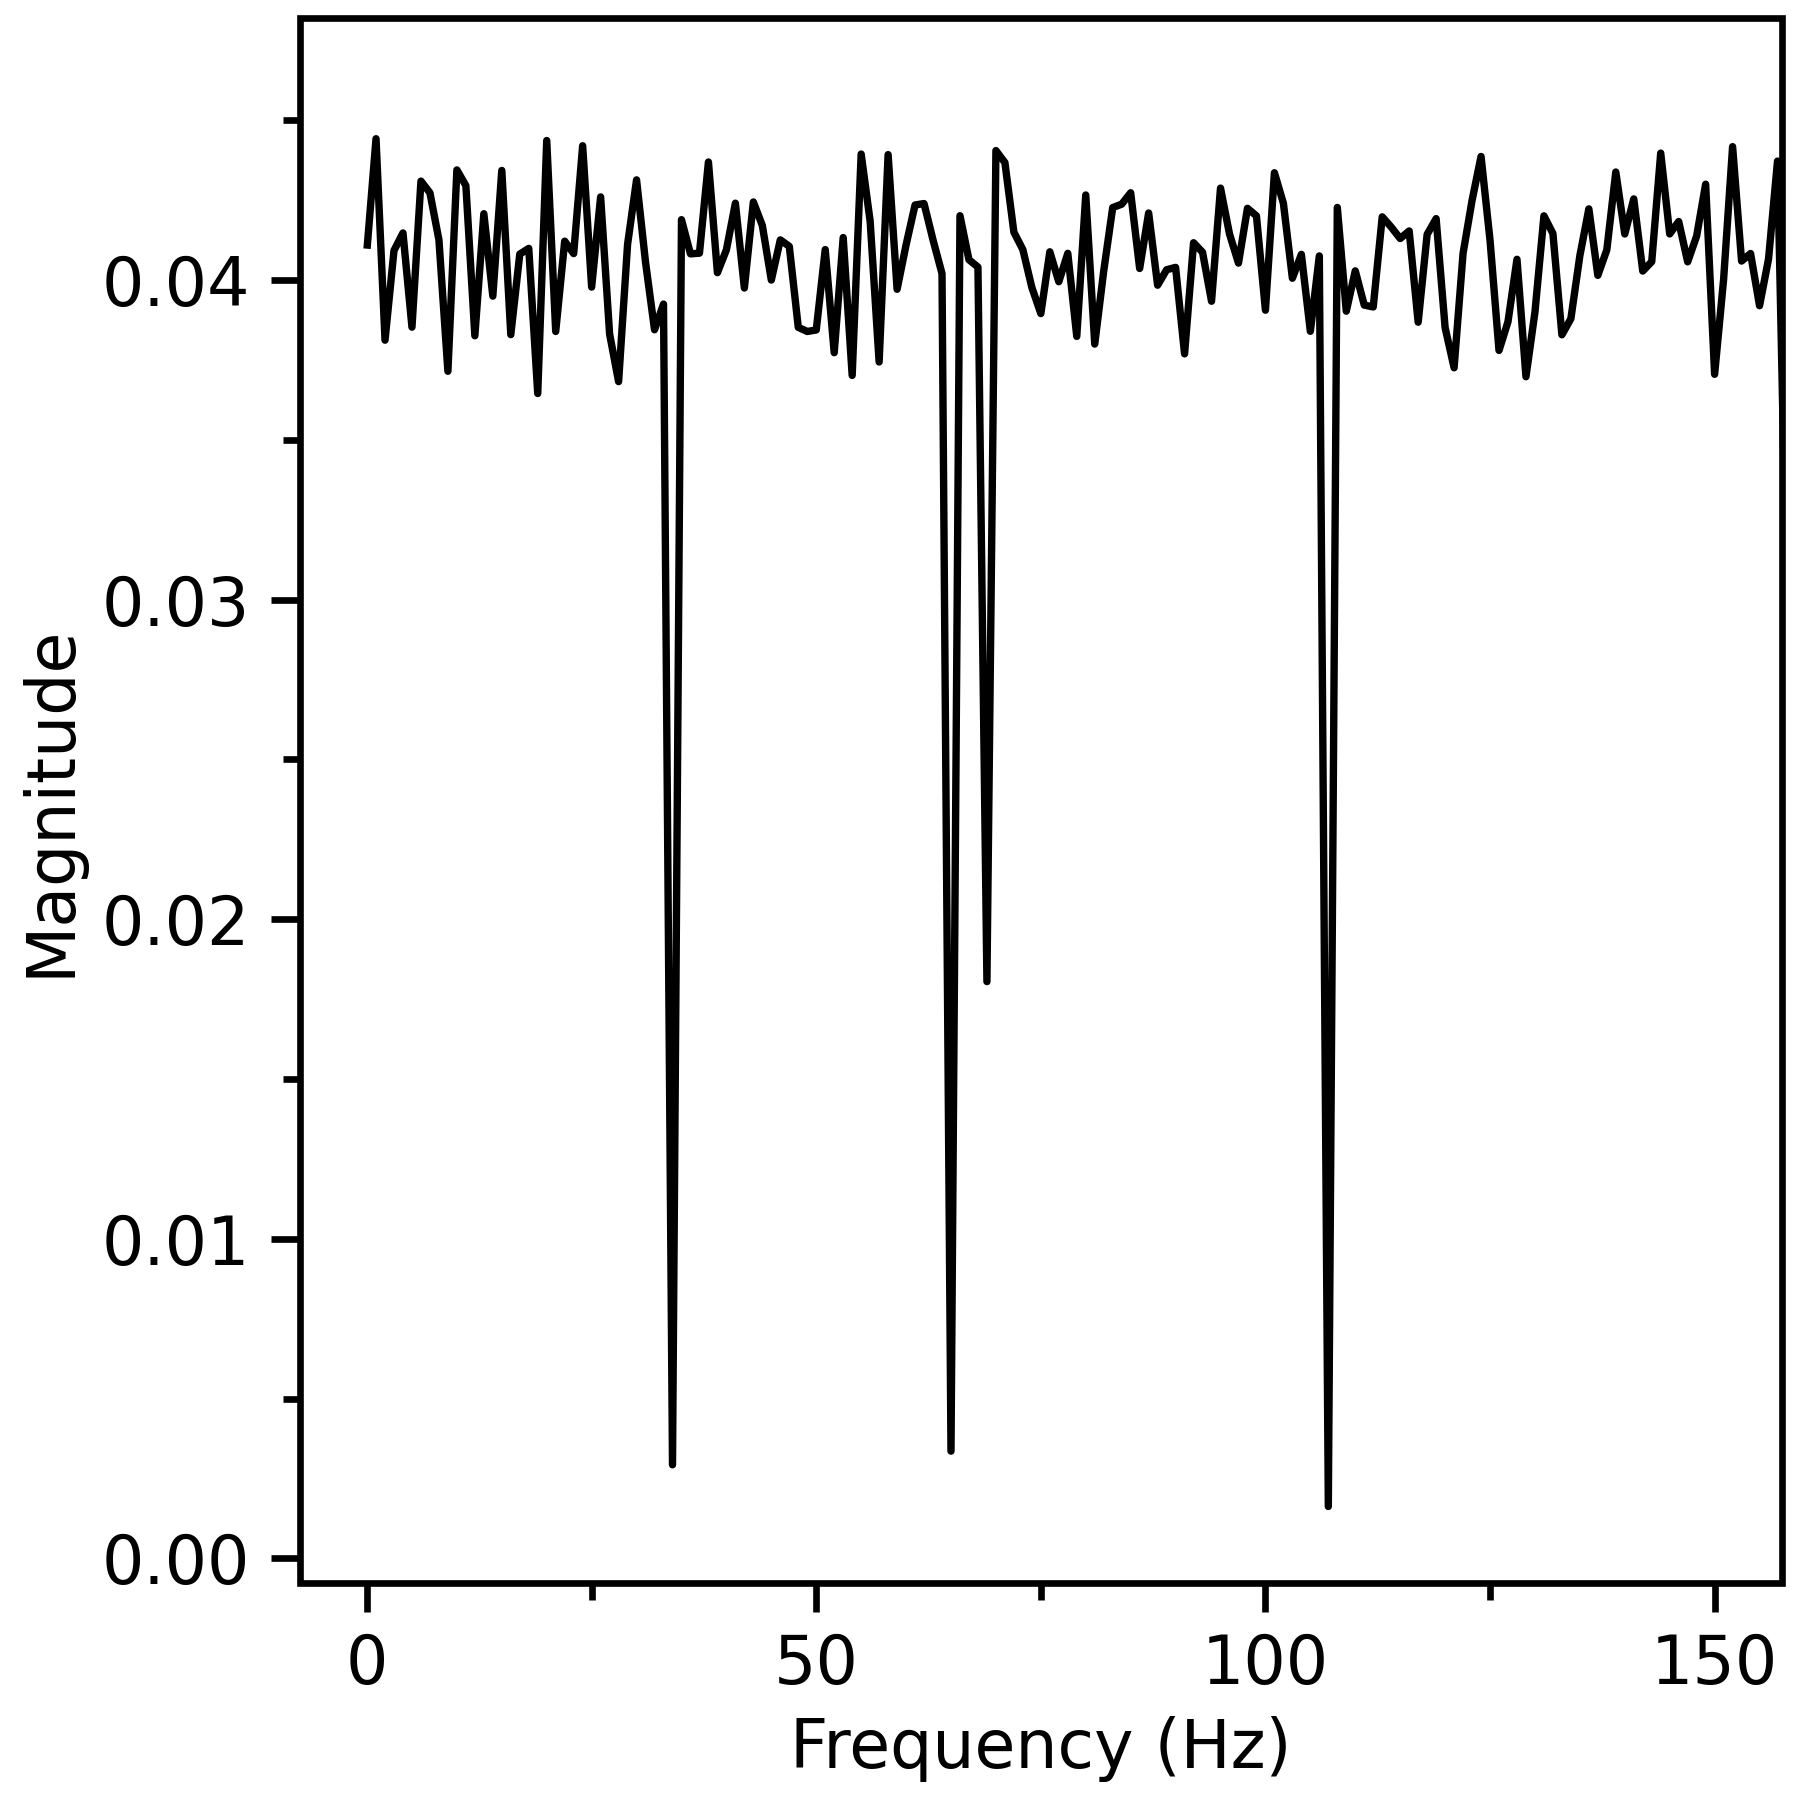

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_fft.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_fft.pdf


In [110]:

fft_fig = (
    p9.ggplot(fft_df, p9.aes(x="frequency", y="magnitude")) +
    p9.geom_line() +
    p9.labs(x="Frequency (Hz)", y="Magnitude") +
    p9.coord_cartesian(xlim=(0, 150)) +
    p9.theme_matplotlib() +
    p9.theme(figure_size=(3, 3), dpi=300, text=p9.element_text(size=8))
)
fft_fig.show()
fft_fig.save("/workspace/output/figures/omt_signal_fft.png")
fft_fig.save("/workspace/output/figures/omt_signal_fft.pdf")


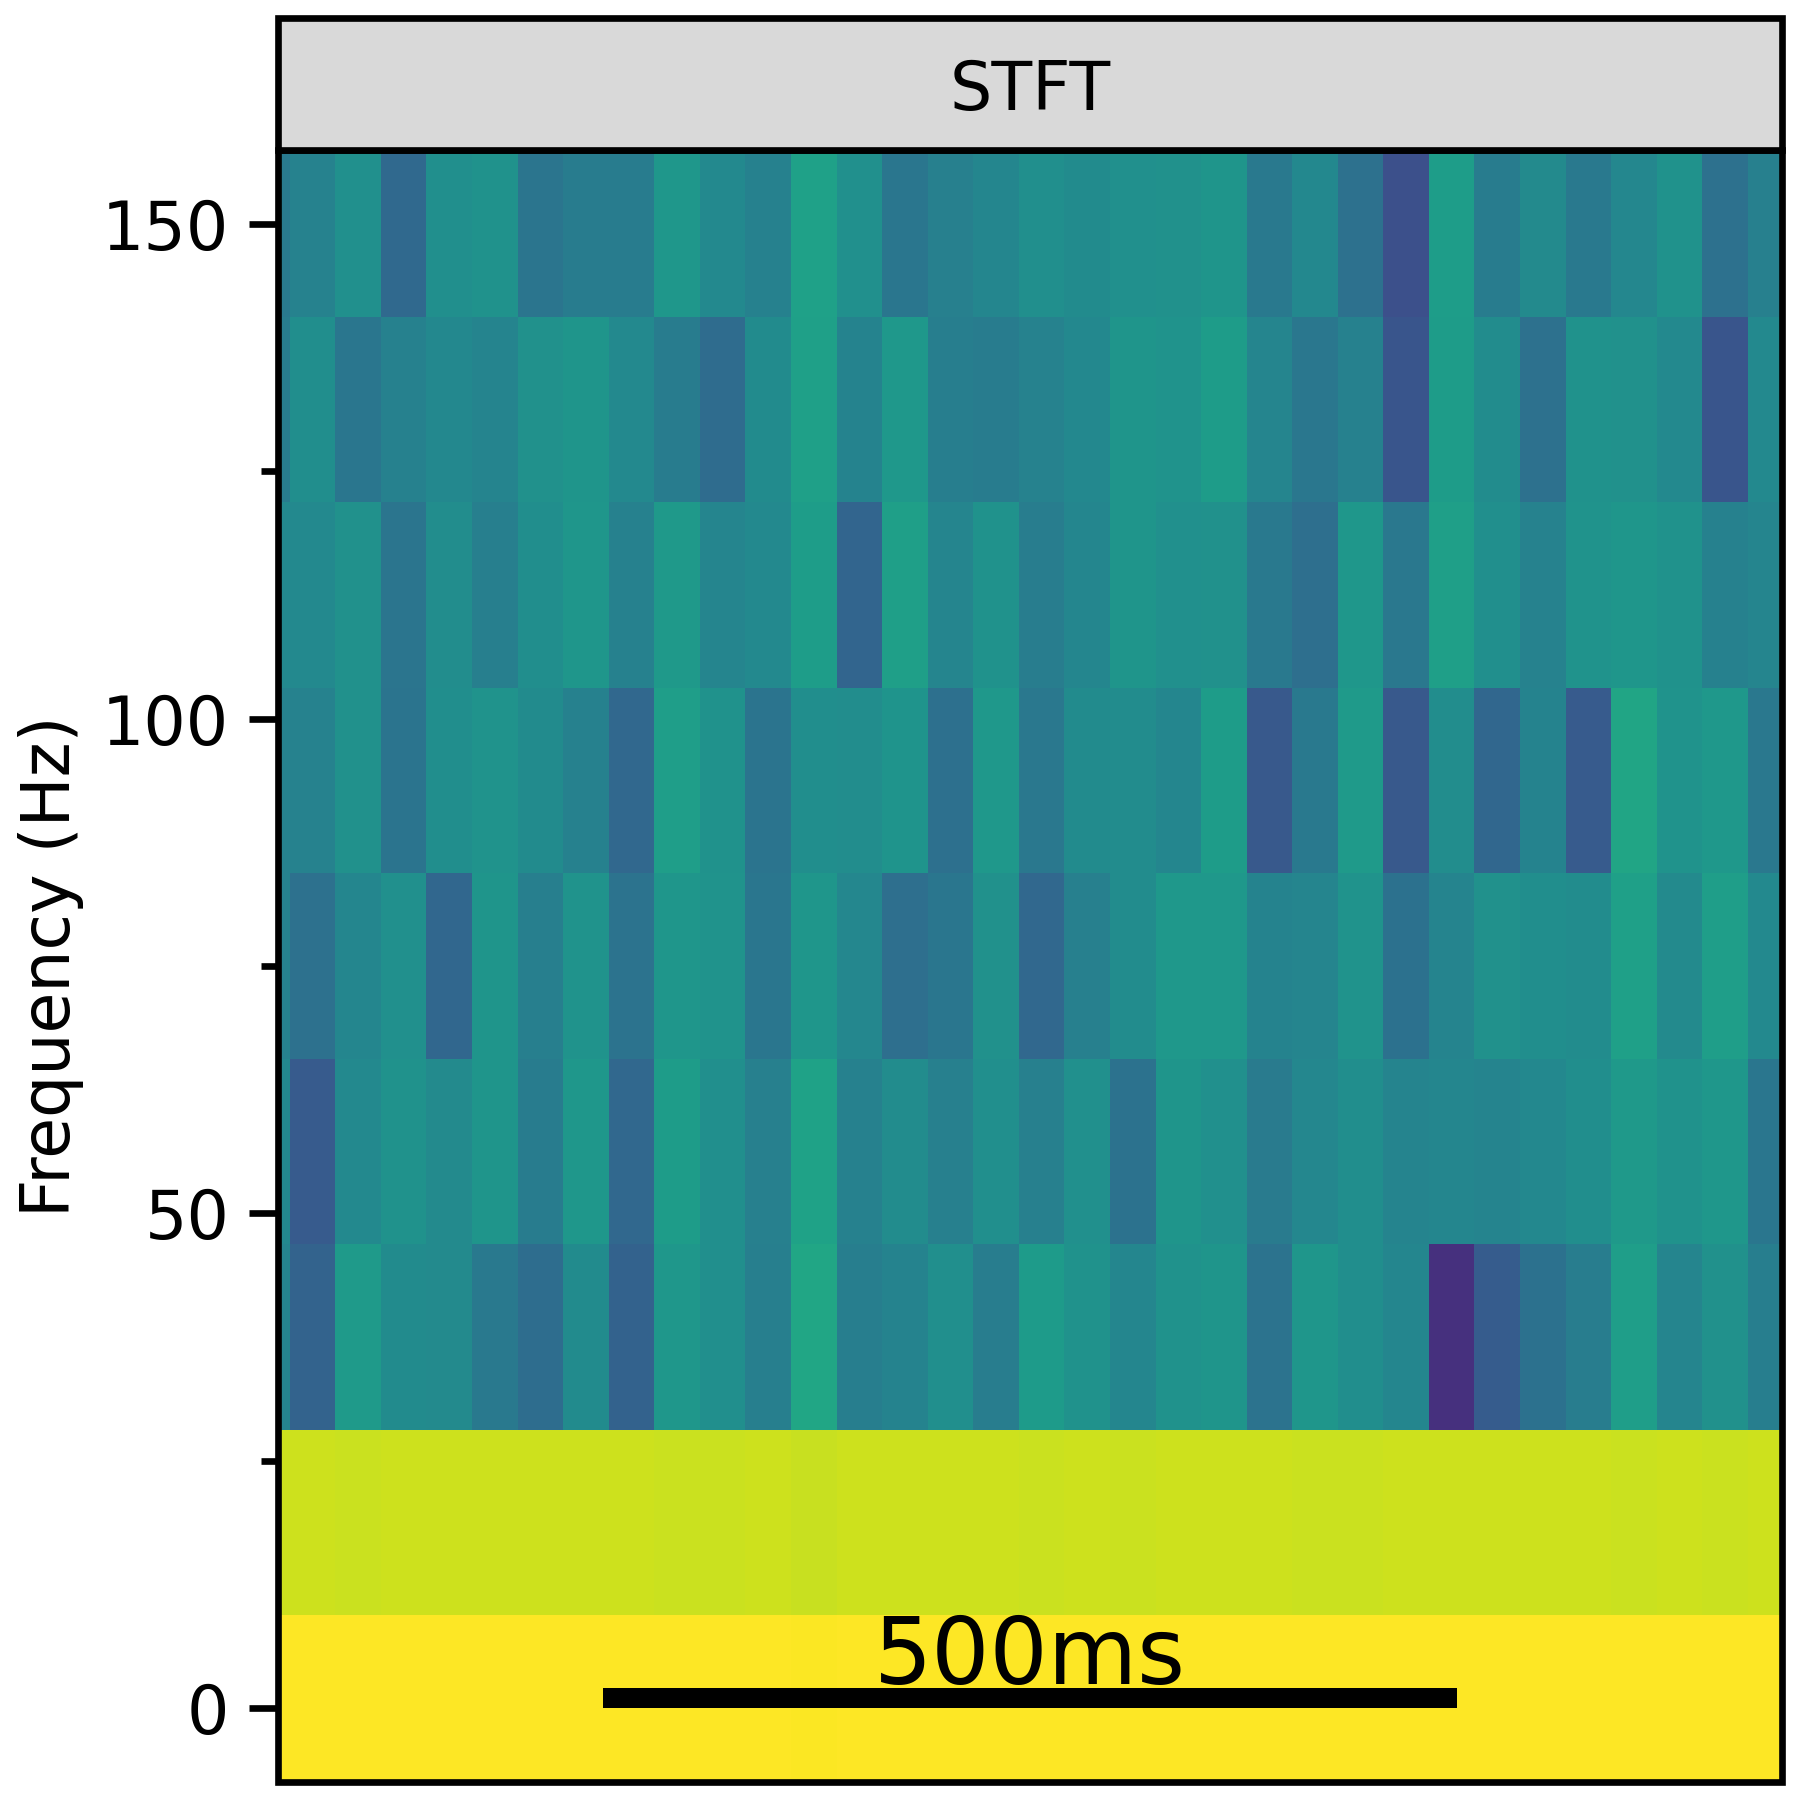

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_stft.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_stft.pdf


In [111]:
# plot the stft of the signal
from scipy.signal import stft
f, t_stft, Zxx = stft(omt_signal.flatten(), fs=fs, nperseg=256, noverlap=128, boundary=None, padded=False, return_onesided=True)
stft_df = pl.DataFrame({
    "frequency": np.tile(f, len(t_stft)),
    "time": np.repeat(t_stft, len(f)),
    "magnitude": np.log(np.abs(Zxx.T.flatten())),
    "type": "STFT"
})
stft_fig = (
    p9.ggplot(stft_df, p9.aes(x="time", y="frequency", fill="magnitude")) +
    p9.geom_tile() +
    p9.facet_wrap("~type", scales="free_y") +
    p9.annotate("rect", xmin=0.25, xmax=0.75, ymin=0, ymax=2, fill="black") +
    p9.annotate("text", x=0.5, y=5, label="500ms", ha="center", color="black") +
    p9.labs(x=False, y="Frequency (Hz)", fill="Magnitude (dB)") +
    p9.coord_cartesian(xlim=(0.1, 0.9), ylim=(0, 150)) +
    p9.guides(fill=False) +
    p9.theme_matplotlib() +
    p9.theme(figure_size=(3, 3), dpi=300, text=p9.element_text(size=8), axis_ticks_x=p9.element_blank(), axis_text_x=p9.element_blank())
)
stft_fig.show()
stft_fig.save("/workspace/output/figures/omt_signal_stft.png")
stft_fig.save("/workspace/output/figures/omt_signal_stft.pdf")


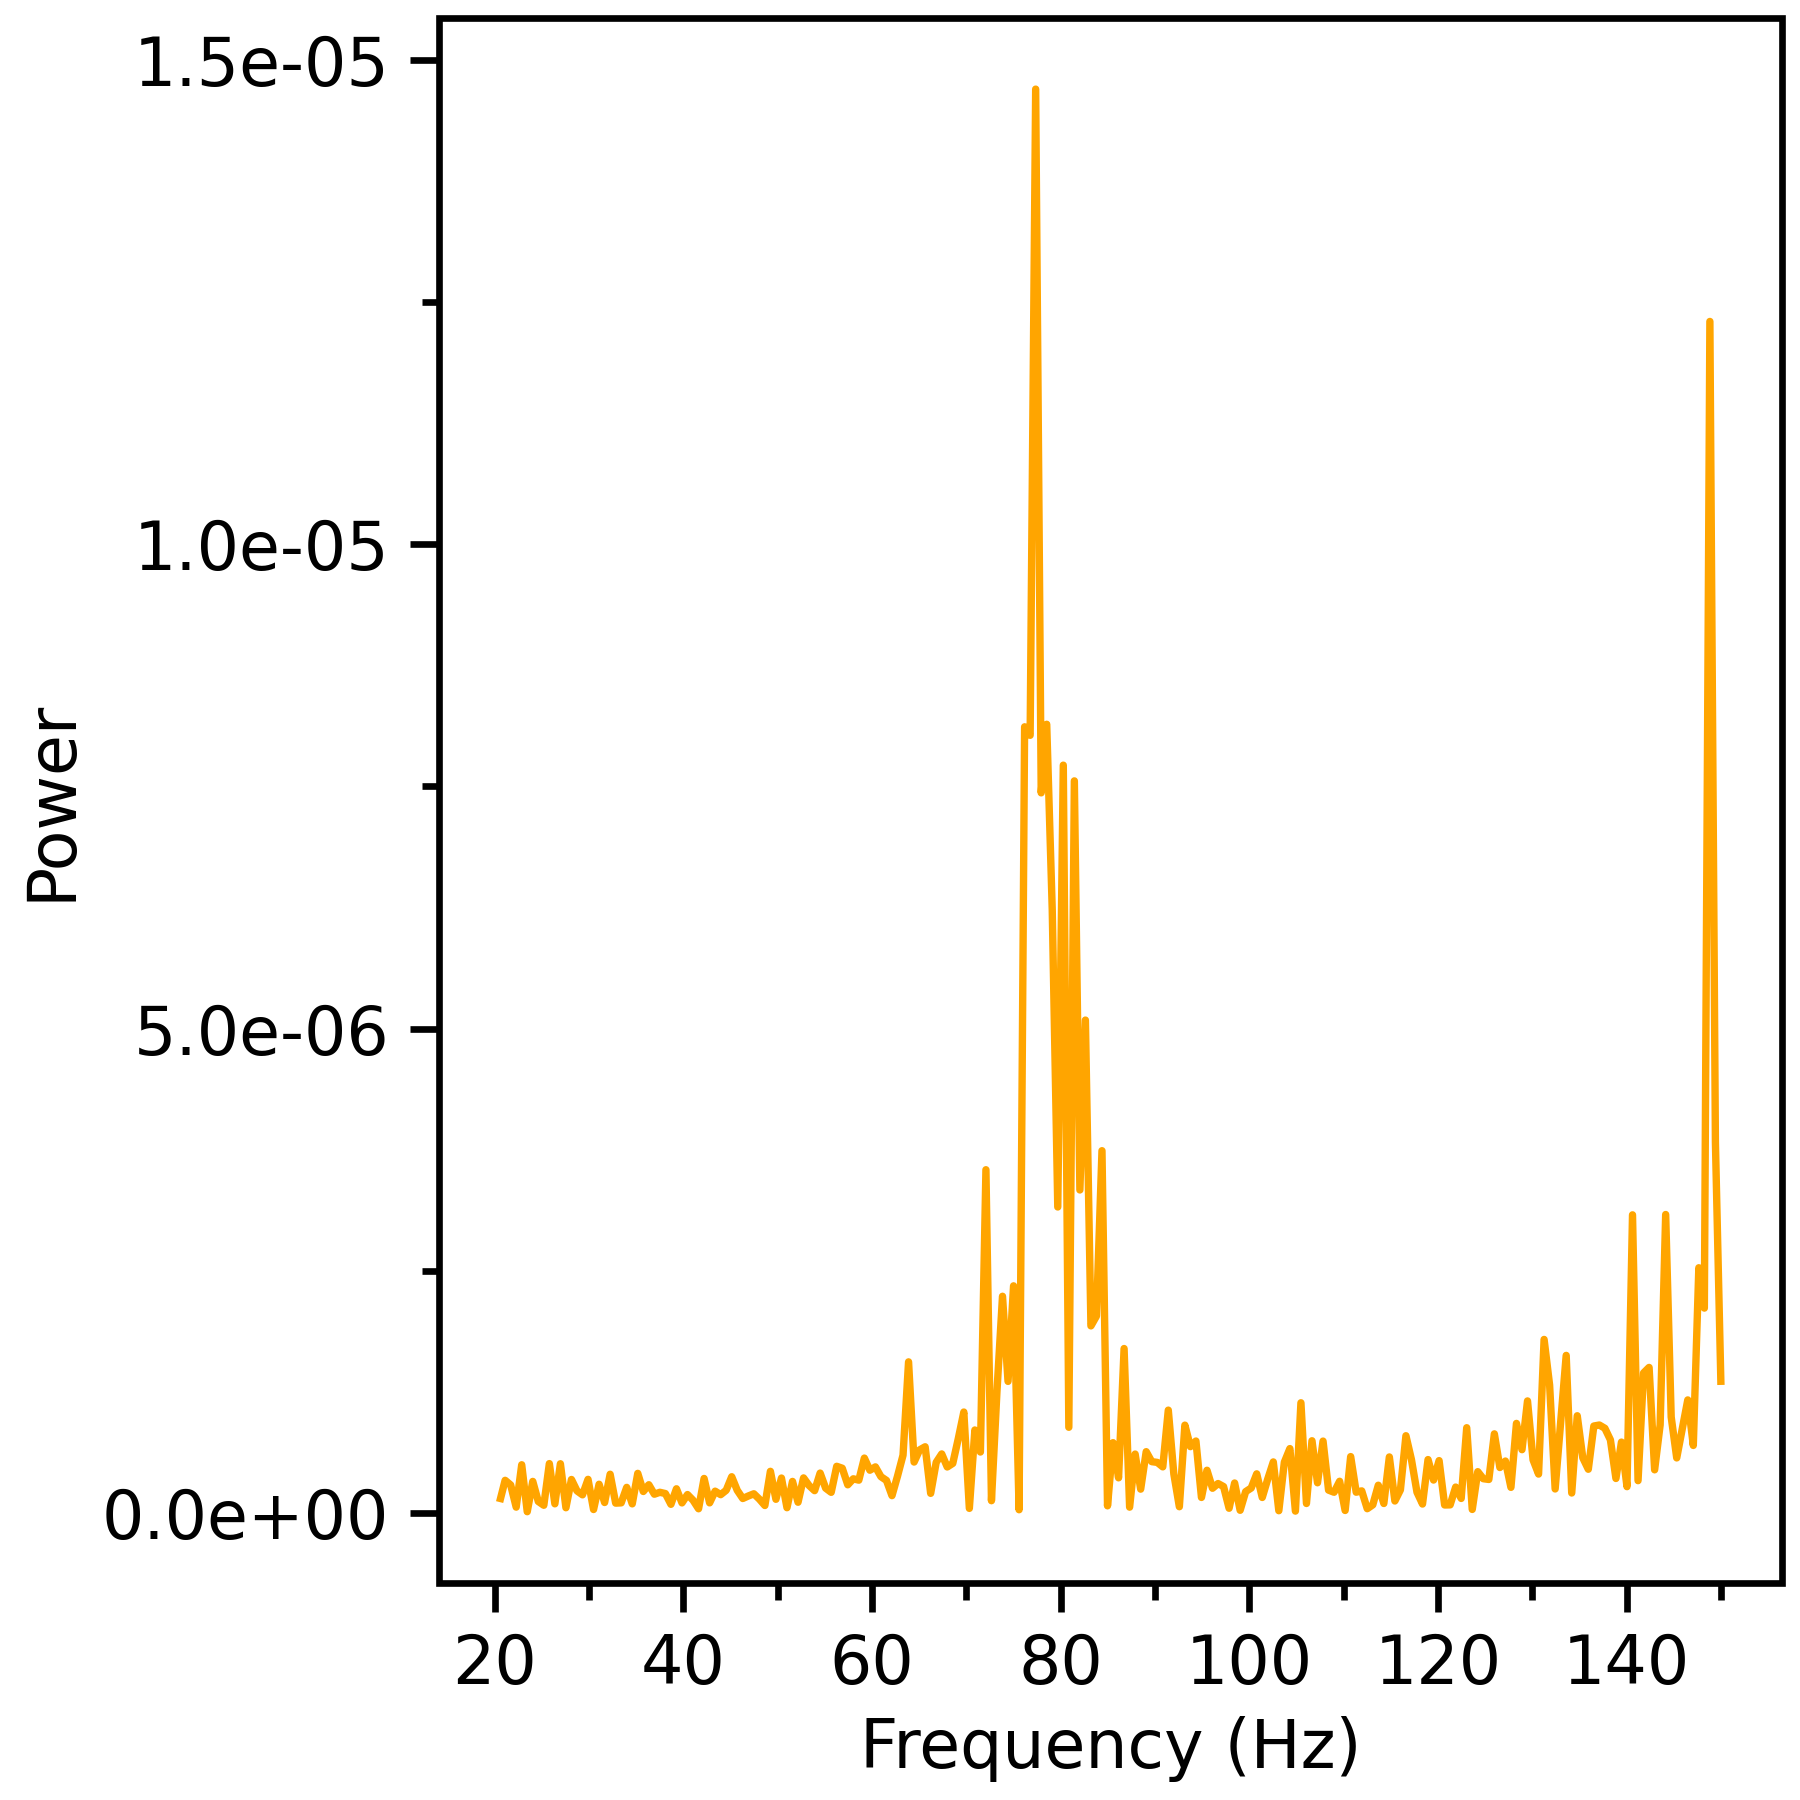

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_power_spectrum.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_power_spectrum.pdf


In [112]:
import numpy as np
from scipy.fft import fft, fftfreq

# --- Generate OMT Signal ---
omt_signal = np.zeros_like(t)
for _ in range(N):
    rate = np.random.normal(central_frequency, 2)  # Hz
    spike_train = generate_spike_train(rate, duration, jitter=0.001, fs=fs)
    response = 1.0 * convolve_spikes_with_twitch(spike_train, fs=fs, tau=tau)
    omt_signal += response

n_fft = 2**int(np.ceil(np.log2(len(omt_signal))))
omt_signal = np.pad(omt_signal, (0, n_fft - len(omt_signal)))
omt_signal -= omt_signal.mean()

# --- Step 4: Deconvolution (Tikhonov Regularisation) ---
t_kernel = np.arange(0, 0.05, 1/fs)
kernel = twitch_kernel(t_kernel, tau)
kernel /= np.sum(kernel) * (1/fs)
omt_signal = omt_signal.flatten()
kernel_padded = np.zeros_like(omt_signal)
kernel_padded[:len(kernel)] = kernel
Y = fft(omt_signal)
H = fft(kernel_padded)
H_conj = np.conj(H)
S_hat_tikhonov = (H_conj / (H_conj * H + tikhonov_lambda)) * Y
s_deconv_tikhonov = np.real(np.fft.ifft(S_hat_tikhonov))
s_deconv_tikhonov -= s_deconv_tikhonov.mean()

# --- Step 5: Power Spectrum ---
N_samples = len(omt_signal)
freqs = fftfreq(N_samples, d=1/fs)[:N_samples//2]
S_deconv_fft = np.abs(fft(s_deconv_tikhonov))[:N_samples//2]
power_spectrum = S_deconv_fft**2

# Limit the frequency range between 20 Hz and 150 Hz
freq_min = 20
freq_max = 150
mask = (freqs >= freq_min) & (freqs <= freq_max)
freqs_limited = freqs[mask]
power_spectrum_limited = power_spectrum[mask]

pl_df = pl.DataFrame({
    "frequency": freqs_limited,
    "power": power_spectrum_limited
})

# --- Step 6: Plotting the Power Spectrum ---
fig = (
    p9.ggplot(pl_df, p9.aes(x="frequency", y="power")) +
    p9.geom_line(color='orange') +
    p9.labs(x="Frequency (Hz)", y="Power") +
    p9.scale_y_continuous(labels=scientific_format(digits=2)) +
    p9.scale_x_continuous(breaks=np.arange(0, freq_max, 20)) +
    p9.theme_matplotlib() +
    p9.theme(figure_size=(3, 3), dpi=300, text=p9.element_text(size=8))
)

fig.show()
fig.save("/workspace/output/figures/omt_signal_power_spectrum.png")
fig.save("/workspace/output/figures/omt_signal_power_spectrum.pdf")


In [113]:
# Find frequency with maximum power (peak)
# Define the frequency band
band_min = 20
band_max = 150

# Mask for frequencies in the desired band
band_mask = (freqs >= band_min) & (freqs <= band_max)

# Apply mask to power spectrum
band_freqs = freqs[band_mask]
band_power = power_spectrum[band_mask]

# Find peak in this band
band_peak_index = np.argmax(band_power)
band_peak_freq = band_freqs[band_peak_index]
band_peak_power = band_power[band_peak_index]

print(f"Band Peak Frequency: {band_peak_freq.item():.1f}Hz, Band Peak Power: {band_peak_power.item()}, Error: {np.abs(band_peak_freq - central_frequency):.1f}Hz")

Band Peak Frequency: 77.3Hz, Band Peak Power: 1.4700490635495144e-05, Error: 2.7Hz


In [114]:
# Parameters
frequencies = np.arange(20, 150, 1)
n_trials = 100

def simulate_and_estimate_peak(rate):
    peak_freqs = []
    for _ in range(n_trials):
        omt_signal = np.zeros_like(t)
        for _ in range(N):
            isi = np.random.normal(1/rate, 0.001, size=int(rate * duration * 2))
            spike_times = np.cumsum(isi)
            spike_times = spike_times[spike_times < duration]
            spike_train = np.zeros_like(t)
            spike_idx = (spike_times * fs).astype(int)
            spike_train[spike_idx] = 1

            t_kernel = np.arange(0, 0.05, 1/fs)
            kernel = twitch_kernel(t_kernel, tau)
            response = convolve(spike_train, kernel, mode="same")
            omt_signal += response

        kernel /= np.sum(kernel) * (1/fs)

        # Zero-padding for FFT
        n_fft = 2**int(np.ceil(np.log2(len(omt_signal))))
        omt_signal = np.pad(omt_signal, (0, n_fft - len(omt_signal)))
        kernel_padded = np.zeros_like(omt_signal)
        kernel_padded[:len(kernel)] = kernel

        Y = fft(omt_signal)
        H = fft(kernel_padded)
        lambda_reg = 1e-5
        H_conj = np.conj(H)
        S_hat_tikhonov = (H_conj / (H_conj * H + lambda_reg)) * Y
        s_deconv = np.real(np.fft.ifft(S_hat_tikhonov))
        s_deconv -= s_deconv.mean()

        N_samples = len(omt_signal)
        freqs_fft = fftfreq(N_samples, d=1/fs)[:N_samples//2]
        S_fft = np.abs(fft(s_deconv))[:N_samples//2]
        power_spectrum = S_fft**2
        band_mask = (freqs_fft >= 20) & (freqs_fft <= 150)
        peak_idx = np.argmax(power_spectrum[band_mask])
        peak_freq = freqs_fft[band_mask][peak_idx]
        peak_freqs.append(peak_freq)

    return np.array(peak_freqs)

# Re-run the sweep with updated function
errors = []
for i, f in enumerate(tqdm(frequencies, desc="Sweeping base frequencies (padded)")):
    detected = simulate_and_estimate_peak(f)
    for peak in detected:
        errors.append((i, f, peak))

# Convert to DataFrame and plot
error_df = pl.DataFrame(errors, schema=["sample", "sim_freq", "obs_freq"], orient="row")
error_df


Sweeping base frequencies (padded):   0%|          | 0/130 [00:00<?, ?it/s]

sample,sim_freq,obs_freq
i64,i64,f64
0,20,39.84375
0,20,39.84375
0,20,39.84375
0,20,39.84375
0,20,39.84375
…,…,…
129,149,138.28125
129,149,144.726562
129,149,144.726562


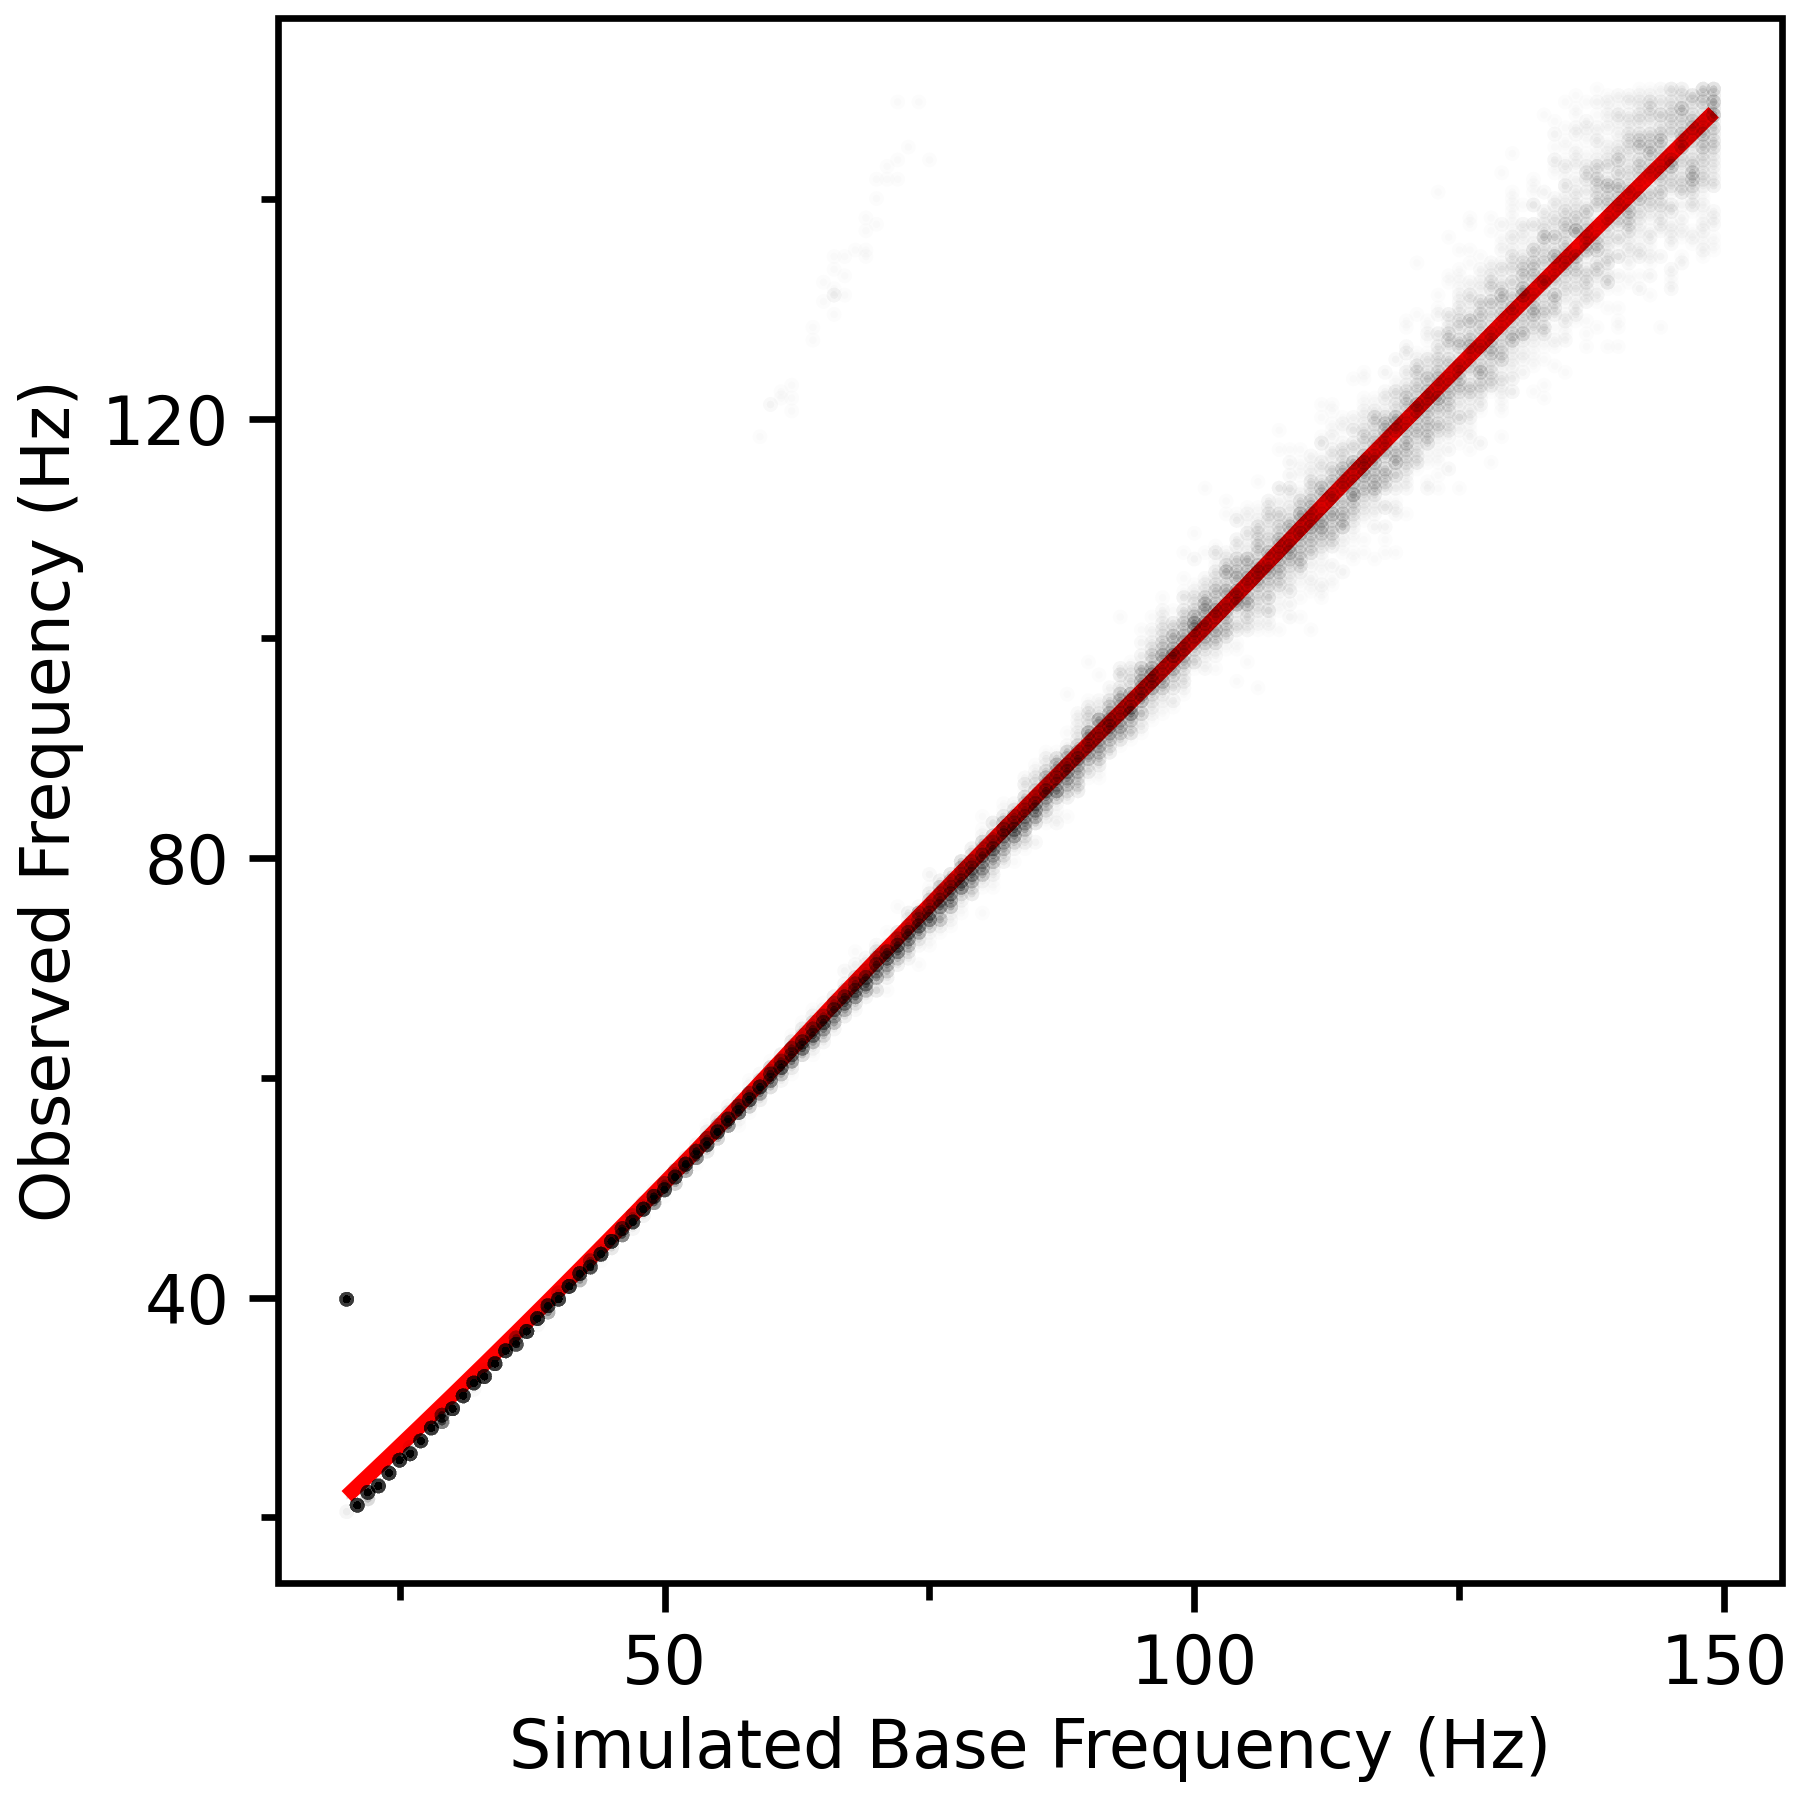

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_frequency_sweep.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_frequency_sweep.pdf


In [115]:
fig = (
    p9.ggplot(error_df, p9.aes(x="sim_freq", y="obs_freq")) +
    p9.geom_smooth(method="loess", color="red") +
    p9.geom_point(size=0.01, alpha=0.01) +
    p9.labs(x="Simulated Base Frequency (Hz)", y="Observed Frequency (Hz)") +
    p9.theme_matplotlib() +
    p9.theme(figure_size=(3, 3), dpi=300, text=p9.element_text(size=8))
)
fig.show()
fig.save("/workspace/output/figures/omt_signal_frequency_sweep.png")
fig.save("/workspace/output/figures/omt_signal_frequency_sweep.pdf")

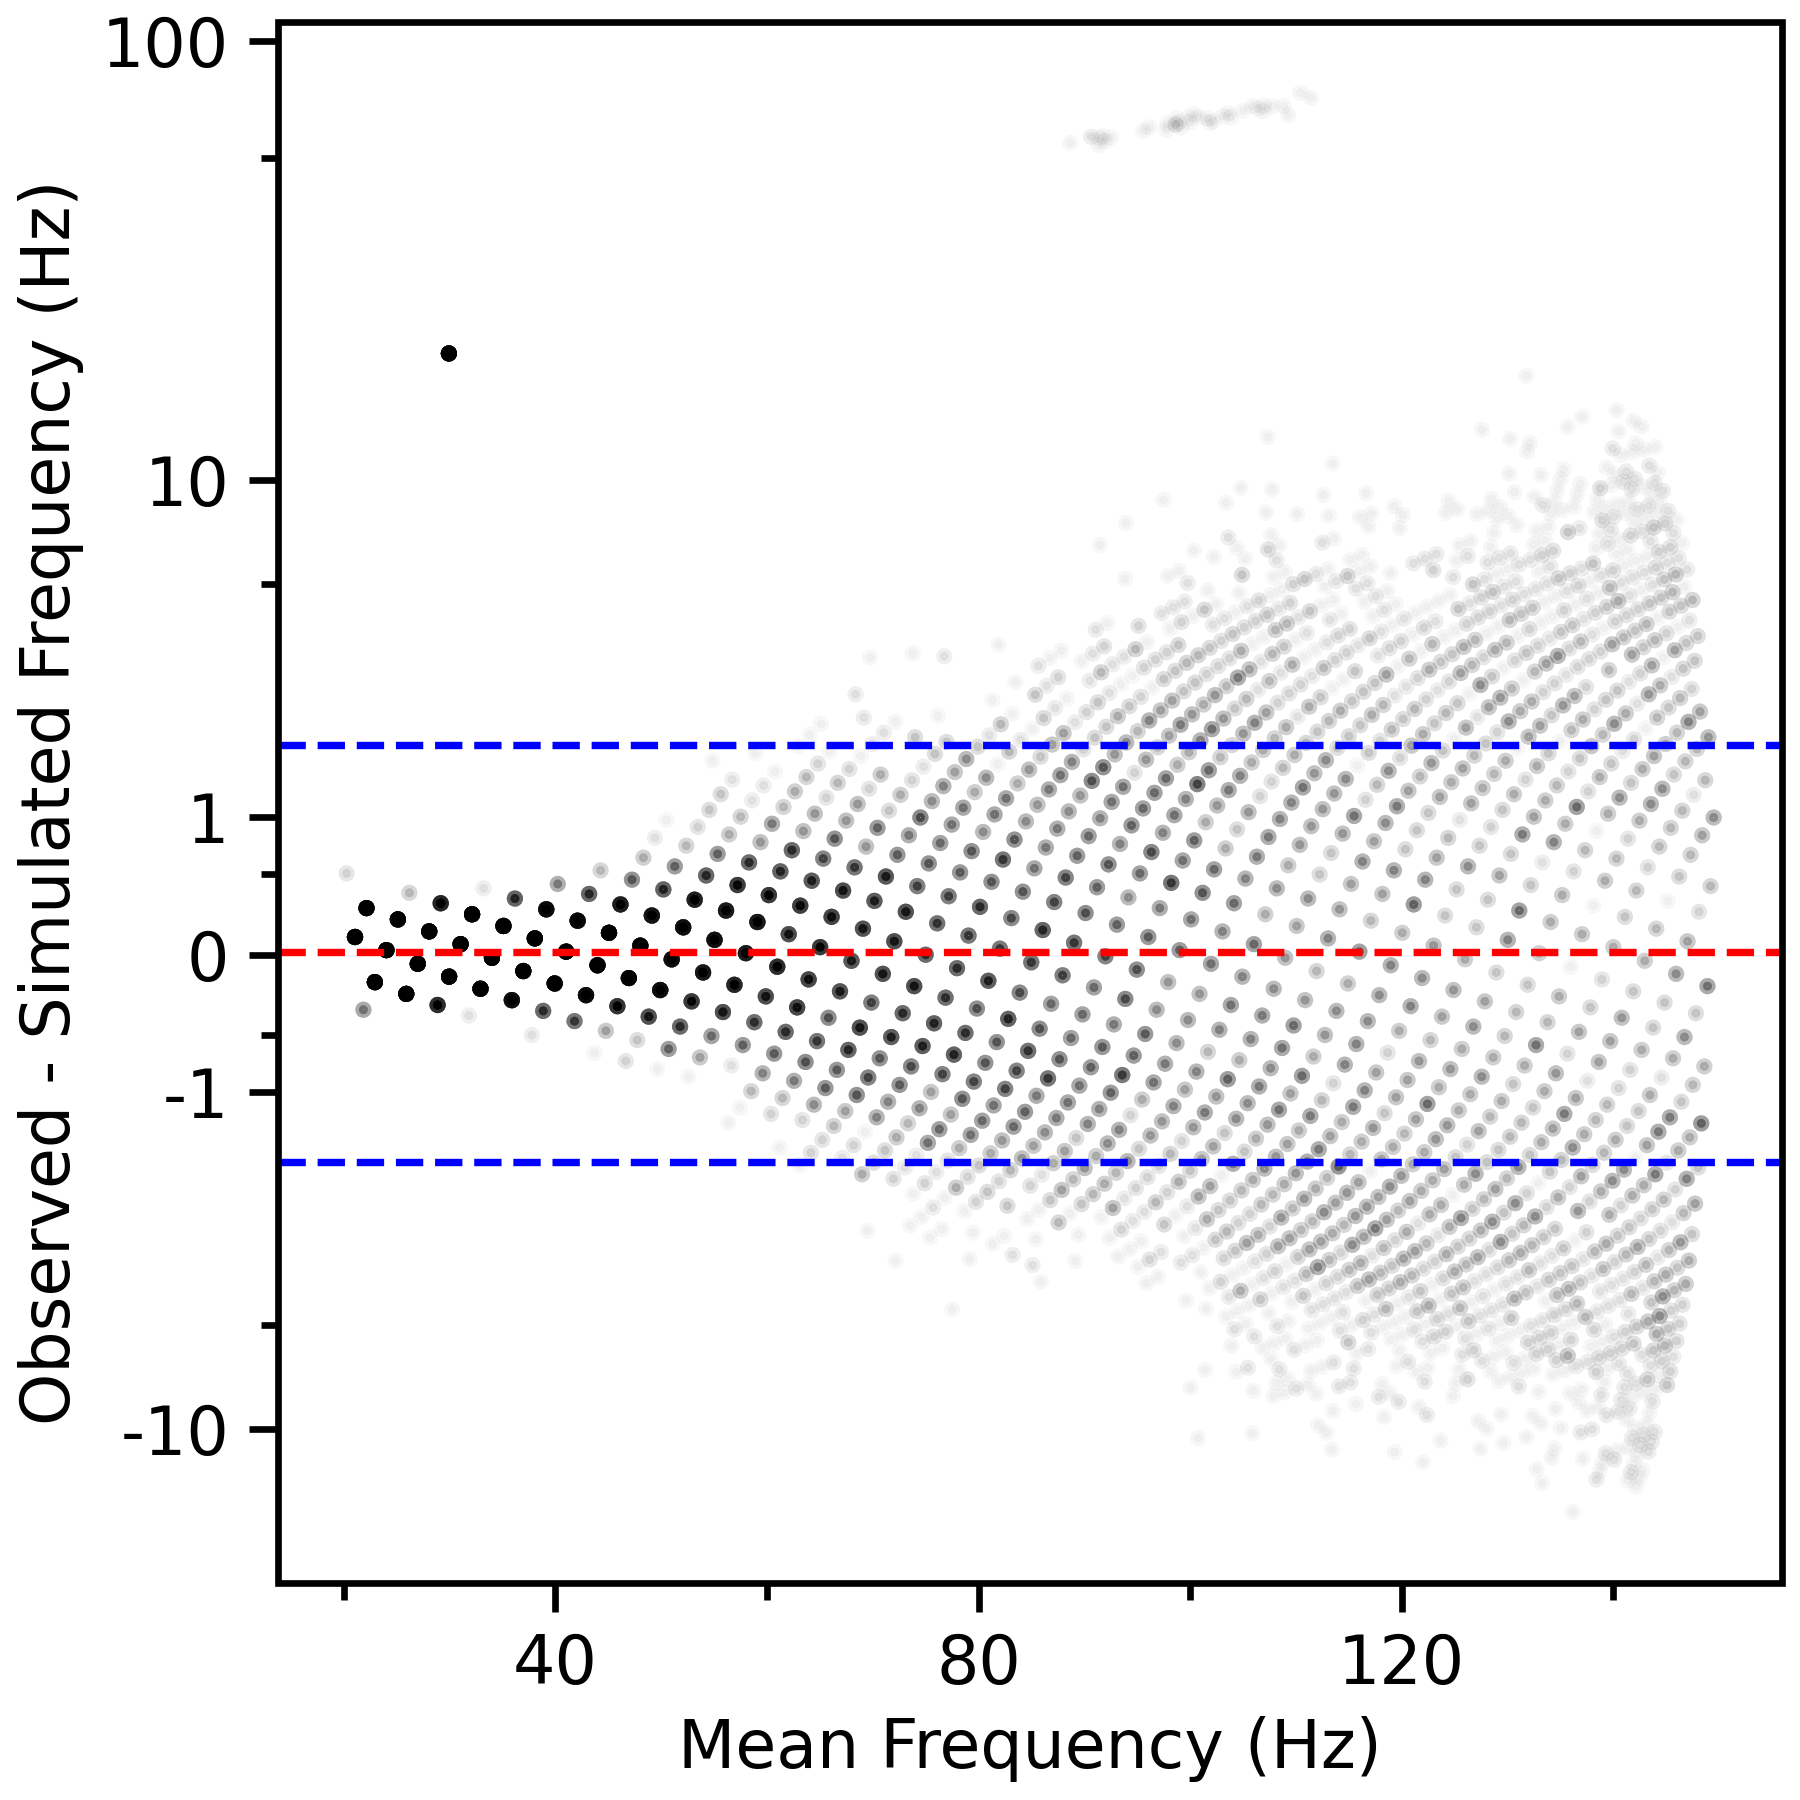

/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_bland_altman_iqr.png
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 3 x 3 in image.
/root/venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /workspace/output/figures/omt_signal_bland_altman_iqr.pdf


In [116]:
# Add Bland-Altman columns
pl_df = error_df.with_columns([
    ((pl.col("sim_freq") + pl.col("obs_freq")) / 2).alias("mean_frequency"),
    (pl.col("obs_freq") - pl.col("sim_freq")).alias("diff_frequency")
])

# Compute mean and limits of agreement
diff_freq = pl_df["diff_frequency"].to_numpy()
# Compute median and IQR for difference
diff_median = np.median(diff_freq)
iqr = np.percentile(diff_freq, 75) - np.percentile(diff_freq, 25)
iqr_upper = diff_median + 1.5 * iqr
iqr_lower = diff_median - 1.5 * iqr

# Update plot with median and IQR-based limits
bland_altman_plot_iqr = (
    p9.ggplot(pl_df, p9.aes(x="mean_frequency", y="diff_frequency")) +
    p9.geom_point(alpha=0.03, size=0.1) +
    p9.geom_hline(yintercept=diff_median, linetype='dashed', color='red') +
    p9.geom_hline(yintercept=iqr_upper, linetype='dashed', color='blue') +
    p9.geom_hline(yintercept=iqr_lower, linetype='dashed', color='blue') +
    p9.scale_y_symlog(breaks=[-10, int(iqr_lower), 0, int(iqr_upper), 10, 100]) +
    p9.labs(
        x="Mean Frequency (Hz)",
        y="Observed - Simulated Frequency (Hz)"
    ) +
    p9.theme_matplotlib() +
    p9.theme(figure_size=(3, 3), dpi=300, text=p9.element_text(size=8))
)

bland_altman_plot_iqr.show()
bland_altman_plot_iqr.save("/workspace/output/figures/omt_signal_bland_altman_iqr.png")
bland_altman_plot_iqr.save("/workspace/output/figures/omt_signal_bland_altman_iqr.pdf")